# Sajad Hosseini Najafabadi
# 400301997
# DL2022_HW4_P1:

In [ ]:
# Install needed package
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
import numpy as np
from itertools import chain
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import random_split
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Download and read ferdousi.txt:

In [ ]:
# download ferdousi.txt from github and remove extra data
!git clone https://github.com/Sajad-Hosseini/Deep-learning
!mv /content/Deep-learning/HW4/Data/ferdousi.txt /content/
!rm -r /content/Deep-learning

Cloning into 'Deep-learning'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 154 (delta 15), reused 0 (delta 0), pack-reused 102
Receiving objects: 100% (154/154), 7.58 MiB | 9.76 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
# read data
with open('/content/ferdousi.txt') as f:
    ferdousi = [line.strip() for line in f]
# remove the first two rows
ferdousi = ferdousi[2:]
# remove the last row because it's not complete
ferdousi = ferdousi[:-1]
# show the first ten rows
ferdousi[:10]

['به نام خداوند جان و خرد',
 'کزین برتر اندیشه برنگذرد',
 'خداوند نام و خداوند جای',
 'خداوند روزی ده رهنمای',
 'خداوند کیوان و گردان سپهر',
 'فروزنده ماه و ناهید و مهر',
 'ز نام و نشان و گمان برترست',
 'نگارندهٔ بر شده پیکرست',
 'به بینندگان آفریننده را',
 'نبینی مرنجان دو بیننده را']

## Make a dictionary of the ferdousi.txt:

In [ ]:
# Extract words from text and find The maximum length of the verse of the poem
max_len = 0
text = []
for line in ferdousi:
  l = line.split(" ")
  text.append(l)
  if len(l) > max_len:
    max_len = len(l)
words = list(chain.from_iterable(text))
# sort the words and make a dictionary of it
dic = list(set(words))
# define some useful special tokens
special_tokens = ['<شروع>','<پدینگ>','<پایان>']
dic[0:0] = special_tokens
# show the first ten items of dic
dic[:10]

['<شروع>',
 '<پدینگ>',
 '<پایان>',
 'زرداب',
 'فرمود',
 'نیزبگذشت',
 'نیکوییها',
 'نامجوی',
 'بجست',
 'دوگوش']

In [ ]:
print(f'The number of unique words detected is: {len(dic)}')

The number of unique words detected is: 18014


## Create the desired dataset:

In [ ]:
# It will take about 2 min to run. But the training will be faster because all 
# the dataset is loaded once (This is not batch size don't misunderstand it please).
y = []
x = []
for i in range(len(text)):
  line = text[i]
  # Padding
  line.extend([special_tokens[1]]*(max_len - len(line)))
  # Put special tokens in it
  line.insert(0,special_tokens[0])
  line.append(special_tokens[-1])
  # word2vec based on our dic
  vec = [dic.index(word) for word in line]
  if i % 2 == 0:
    x.append(vec)
  else:
    y.append(vec)

ds_x = torch.tensor(x)
ds_y = torch.tensor(y)
ds = torch.utils.data.TensorDataset(ds_x, ds_y)

## Create the desired dataloader:

In [ ]:
Ds = random_split(ds, [0.85, 0.15])
batch_size = 64
train_dataloader = DataLoader(Ds[0], batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(Ds[1], batch_size = batch_size)

# Training:

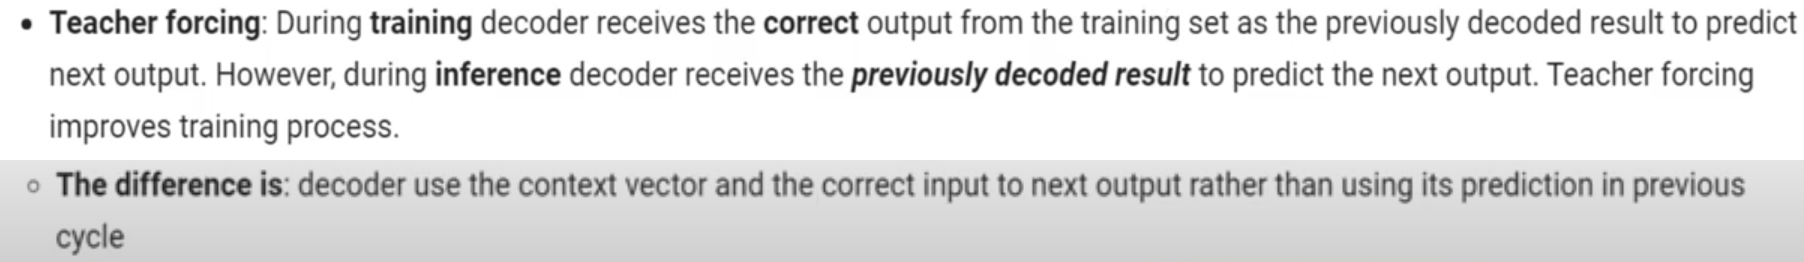

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model([X, y])
        pred = pred.permute(0, 2, 1)
        y = y[:, 1:]
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():.3f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
  num_batches = len(dataloader)
  test_loss = 0
  acc = 0
  with torch.no_grad():
    for X, y in dataloader:
      (X, y) = (X.to(device), y.to(device))
      pred = model([X, y])
      pred = pred.permute(0, 2, 1)
      y = y[:, 1:]
      test_loss += loss_fn(pred, y)
      acc += (pred.argmax(1) == y).sum().type(torch.float) / (y.shape[0] * y.shape[1])
    test_loss /= num_batches
    acc /= num_batches
    print(f'Accuracy: {(100*acc):>0.1f}%, Average test loss: {test_loss.item():.3f}')
  return test_loss

# LSTM:

In [ ]:
class LSTM(nn.Module):

    def __init__(self):
        super().__init__()
        # Eencoder
        self.embedding = nn.Embedding(num_embeddings = len(dic), embedding_dim= 200)
        self.lstm = nn.LSTM(input_size = 200, hidden_size = 600, num_layers = 2,
                            batch_first = True)
        # Decoder (This is not a symmetrical encoder/decoder).
        self.dense = nn.Linear(in_features = 600, out_features= len(dic))

    def forward(self, X):
        # Prepare data for teacher forcing
        data = torch.cat((X[0][:, 1:], X[1][:, :-1]), dim = -1)
        x = self.embedding(data)
        x, _ = self.lstm(x)
        x = self.dense(x)
        return x[:, 1+max_len:, :]     

In [ ]:
model_lstm = LSTM()
model_lstm.to(device)
print(f'Device: {device}')
print("Network Architecture:")
print(model_lstm)

Device: cuda
Network Architecture:
LSTM(
  (embedding): Embedding(18014, 200)
  (lstm): LSTM(200, 600, num_layers=2, batch_first=True)
  (dense): Linear(in_features=600, out_features=18014, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr = 5e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
epoch = 20
best_test_loss = np.Inf
patient = k = 3
for epc in range(epoch):
    print(f'\nEpoch: {epc+1}\n----------------------------------------')
    model_lstm.train()
    train_loop(train_dataloader, model_lstm, loss_fn, optimizer)
    model_lstm.eval()
    print("Test Results:")
    test_loss = test_loop(test_dataloader, model_lstm, loss_fn)
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model_lstm, './best_model_lstm.h5')
      patient = k
    else:
      patient -= 1
      if patient == 0:
        print('Eearly stopping!') 
        break
if patient !=0:
  print('Done!')
model_lstm = torch.load('./best_model_lstm.h5')
print(f'best test loss for LSTM: {best_test_loss:.3f}')


Epoch: 1
----------------------------------------
loss: 9.791  [    0/42167]
loss: 3.742  [ 6400/42167]
loss: 3.487  [12800/42167]
loss: 3.340  [19200/42167]
loss: 3.453  [25600/42167]
loss: 3.380  [32000/42167]
loss: 3.354  [38400/42167]
Test Results:
Accuracy: 55.1%, Average test loss: 3.241

Epoch: 2
----------------------------------------
loss: 3.201  [    0/42167]
loss: 3.050  [ 6400/42167]
loss: 3.162  [12800/42167]
loss: 3.215  [19200/42167]
loss: 3.114  [25600/42167]
loss: 3.168  [32000/42167]
loss: 3.147  [38400/42167]
Test Results:
Accuracy: 55.8%, Average test loss: 3.118

Epoch: 3
----------------------------------------
loss: 3.042  [    0/42167]
loss: 3.058  [ 6400/42167]
loss: 3.057  [12800/42167]
loss: 2.915  [19200/42167]
loss: 3.093  [25600/42167]
loss: 2.863  [32000/42167]
loss: 2.926  [38400/42167]
Test Results:
Accuracy: 56.6%, Average test loss: 3.000

Epoch: 4
----------------------------------------
loss: 2.862  [    0/42167]
loss: 2.706  [ 6400/42167]
loss: 2

In [ ]:
# If you want to save time, load the trained model instead of training it.
# !gdown 1rlEWw8ga6XwJC6yZ462KCbFynY_JpNfm
# model_lstm = torch.load('./best_model_lstm.h5', map_location=torch.device(device))

# GRU

In [ ]:
class GRU(nn.Module):

    def __init__(self):
        super().__init__()
        # Eencoder
        self.embedding = nn.Embedding(num_embeddings = len(dic), embedding_dim= 200)
        self.gru = nn.GRU(input_size = 200, num_layers = 2, hidden_size = 600,
                            batch_first = True)
        # Decoder (This is not a symmetrical encoder/decoder).
        self.dense = nn.Linear(in_features = 600, out_features= len(dic))

    def forward(self, X):
        # Prepare data for teacher forcing
        data = torch.cat((X[0][:, 1:], X[1][:, :-1]), dim = -1)
        x = self.embedding(data)
        x, _ = self.gru(x)
        x = self.dense(x)
        return x[:, 1+max_len:, :]     

In [ ]:
model_gru = GRU()
model_gru.to(device)
print(f'Device: {device}')
print("Network Architecture:")
print(model_gru)

Device: cuda
Network Architecture:
GRU(
  (embedding): Embedding(18014, 200)
  (gru): GRU(200, 600, num_layers=2, batch_first=True)
  (dense): Linear(in_features=600, out_features=18014, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model_gru.parameters(), lr = 5e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
epoch = 20
best_test_loss = np.Inf
patient = k = 3
for epc in range(epoch):
    print(f'\nEpoch: {epc+1}\n----------------------------------------')
    model_gru.train()
    train_loop(train_dataloader, model_gru, loss_fn, optimizer)
    model_gru.eval()
    print("Test Results:")
    test_loss = test_loop(test_dataloader, model_gru, loss_fn)
    if test_loss < best_test_loss:
      best_test_loss = test_loss
      torch.save(model_gru, './best_model_gru.h5')
      patient = k
    else:
      patient -= 1
      if patient == 0:
        print('Eearly stopping!') 
        break
if patient !=0:
  print('Done!')
model_gru = torch.load('./best_model_gru.h5')
print(f'best test loss for GRU: {best_test_loss:.3f}')


Epoch: 1
----------------------------------------
loss: 9.790  [    0/42167]
loss: 3.535  [ 6400/42167]
loss: 3.438  [12800/42167]
loss: 3.403  [19200/42167]
loss: 3.368  [25600/42167]
loss: 3.332  [32000/42167]
loss: 3.148  [38400/42167]
Test Results:
Accuracy: 56.0%, Average test loss: 3.135

Epoch: 2
----------------------------------------
loss: 3.029  [    0/42167]
loss: 3.057  [ 6400/42167]
loss: 3.064  [12800/42167]
loss: 2.994  [19200/42167]
loss: 3.002  [25600/42167]
loss: 2.906  [32000/42167]
loss: 2.796  [38400/42167]
Test Results:
Accuracy: 57.8%, Average test loss: 2.867

Epoch: 3
----------------------------------------
loss: 2.498  [    0/42167]
loss: 2.565  [ 6400/42167]
loss: 2.772  [12800/42167]
loss: 2.584  [19200/42167]
loss: 2.572  [25600/42167]
loss: 2.484  [32000/42167]
loss: 2.305  [38400/42167]
Test Results:
Accuracy: 60.0%, Average test loss: 2.660

Epoch: 4
----------------------------------------
loss: 2.202  [    0/42167]
loss: 2.269  [ 6400/42167]
loss: 2

In [ ]:
# If you want to save time, load the trained model instead of training it.
# !gdown 1--Zwid68lt7pSGz-1--6U6Pzk1CrXchp
# model_lstm = torch.load('./best_model_lstm.h5', map_location=torch.device(device))

GRU performed better than LSTM in this problem.

loss: 2.477 < 2.498

accuracy: 62.7% = 62.7 %

Also GRU was faster than LSTM.

# Generating verse:
# LSTM:

In [ ]:
X = []
Y = []
Pred = []
for k in range(10):
  x, y = test_dataloader.dataset[np.random.default_rng(seed = k).integers(len(test_dataloader.dataset))]
  x = x.to(device)
  pred = torch.zeros_like(x)
  # Feed first verse to network to initialize ht, ct
  z = model_lstm.embedding(x)
  _, (ht, ct) = model_lstm.lstm(z)
  # start from <شروع>
  w = x[0].unsqueeze(-1)
  # predict second verse
  for t in range(max_len):
    z = model_lstm.embedding(w)
    ot, (ht, ct) = model_lstm.lstm(z, (ht, ct))
    ot = model_lstm.dense(ot)
    w = torch.argmax(ot, dim = -1)
    pred[t] = w
  # remove special tokens
  pred = pred[pred >2].tolist()
  # vec2word
  pred=[dic[i] for i in pred]
  pred = ' '.join(pred)

  x = x[x >2].tolist()
  x=[dic[i] for i in x]
  x = ' '.join(x)

  y = y[y >2].tolist()
  y=[dic[i] for i in y]
  y = ' '.join(y)

  Pred.append(pred)
  X.append(x)
  Y.append(y)

poem = pd.DataFrame(Pred, columns=['مصرع دوم تولید شده توسط شبکه'])
poem['مصرع اصلی دوم'] = Y
poem['مصرع اصلی اول'] = X
poem

,مصرع دوم تولید شده توسط شبکه,مصرع اصلی دوم,مصرع اصلی اول
0,به فرمان و رایت سرافگنده ام,همان نیروی جان وگر توش من,نگهدار دین و تن و هوش من
1,به پیش اندرون شهریار بلند,ورا پهلوانی همی خواندند,چنین تا بتازی سخن راندند
2,به نزدیک آن نامور پیشگاه,ز دروازه تا پیش درگاه شاه,به بازار گه بسته آیین به راه
3,ز هر گونه ای لابد و از بیش و کم,برین کین ما بر نبگذشت شب,ازان پس که جانم رسیده به لب
4,ز هر سو که بد شاه ایران زمین,بیاری بیاید بدین انجمن,بنیروی یزدان گو پیلتن
5,که از شاه ایران نماند بلند,به تو تیرگیها برافروختند,بزرگان ز تو دانش آموختند
6,به نزدیک آن نامور بازشو,وکرد ایزدش را برین بر گوای,مر او را دهم دخترم را همای
7,به پیش اندرون شهریار بلند,به دل زنده و مردگان منند,سپاهت همه بندگان منند
8,به گیتی به جز راه دیدار نیست,بمغز تو پند مرا جای نیست,جز از رزم و خون کردنت رای نیست
9,که از شاه ایران چه آمد به سر,که تندی نه خوب آید از شهریار,سخنها شنیدی تو پاسخ گزار


# GRU:

In [ ]:
X = []
Y = []
Pred = []
for k in range(10):
  x, y = test_dataloader.dataset[np.random.default_rng(seed = k).integers(len(test_dataloader.dataset))]
  x = x.to(device)
  pred = torch.zeros_like(x)
  # Feed first verse to network to initialize ht, ct
  z = model_gru.embedding(x)
  _, ht = model_gru.gru(z)
  # start from <شروع>
  w = x[0].unsqueeze(-1)
  # predict second verse
  for t in range(max_len):
    z = model_gru.embedding(w)
    ot, ht = model_gru.gru(z, ht)
    ot = model_gru.dense(ot)
    w = torch.argmax(ot, dim = -1)
    pred[t] = w
  # remove special tokens
  pred = pred[pred >2].tolist()
  # vec2word
  pred=[dic[i] for i in pred]
  pred = ' '.join(pred)

  x = x[x >2].tolist()
  x=[dic[i] for i in x]
  x = ' '.join(x)

  y = y[y >2].tolist()
  y=[dic[i] for i in y]
  y = ' '.join(y)

  Pred.append(pred)
  X.append(x)
  Y.append(y)

poem = pd.DataFrame(Pred, columns=['مصرع دوم تولید شده توسط شبکه'])
poem['مصرع اصلی دوم'] = Y
poem['مصرع اصلی اول'] = X
poem

,مصرع دوم تولید شده توسط شبکه,مصرع اصلی دوم,مصرع اصلی اول
0,ز گیتی کسی نیست این مرز و بوم,همان نیروی جان وگر توش من,نگهدار دین و تن و هوش من
1,به پیش اندرون شاه را خواندند,ورا پهلوانی همی خواندند,چنین تا بتازی سخن راندند
2,به شادی و به بزم و به تخت و کلاه,ز دروازه تا پیش درگاه شاه,به بازار گه بسته آیین به راه
3,ز خون ریختن بر سر انجمن,برین کین ما بر نبگذشت شب,ازان پس که جانم رسیده به لب
4,ز بهر پرستش فراوان نماند,بیاری بیاید بدین انجمن,بنیروی یزدان گو پیلتن
5,ز لشکر که دارد دل و رای زن,به تو تیرگیها برافروختند,بزرگان ز تو دانش آموختند
6,ز داد و ز بخشش و از داد و داد,وکرد ایزدش را برین بر گوای,مر او را دهم دخترم را همای
7,به پیش اندرون شاه را رهنمای,به دل زنده و مردگان منند,سپاهت همه بندگان منند
8,که با او سواری به پیکار نیست,بمغز تو پند مرا جای نیست,جز از رزم و خون کردنت رای نیست
9,که از پهلوانان همی ننگرند,که تندی نه خوب آید از شهریار,سخنها شنیدی تو پاسخ گزار
